In [1]:
with open('RDE_1 JDLE-12.dat', 'r', encoding='ISO-8859-1') as archivo:
    contenido = archivo.read()
    print(contenido)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [1]:
from asammdf import MDF
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import plotly.graph_objects as go

# Carga el archivo .DAT
mdf = MDF('RDE_1 JDLE-12.dat')

#Extraer los datos de las variables de interes de VEHICULO
datosRPM = mdf.get('PID0C_engineRPM')[:] 
datosVEL = mdf.get('PID0D_vehicleSpeedSensor')[:] 
datosTCO = mdf.get('PID05_engineCoolantTemperature')[:] 
datosTime = mdf.get('PID1F_timeSinceEngineStart')[:]
# datosInyt = mdf.get("PID5D_FuelInjectionTiming")[:]
# datosCataT = mdf.get("PID3C_catalystTemperature")[:]
# datosTPS = mdf.get("PID49_acceleratorPedalPositionD")[:]
# datosIAT = mdf.get("PID10_airFlowRateFromMassAirFlowSensor")


#Extraer los datos de las variables de interes de GPS
datoslat = mdf.get('Latitude')[:] 
datoslong = mdf.get('Longitude')[:] 
datosAltitude = mdf.get('Altitude')[:] 
datosUTC_Time = mdf.get('UTC_Time')[:]
datosSpeed = mdf.get('Speed')[:] 

ldf is not supported
xls is not supported
xlsx is not supported


In [2]:
# Tiempo de grabacion usando PID1F_timeSinceEngineStart ---- OBD
df1 = pd.DataFrame() #crear dataframe
df1['time'] = datosTime
t_record = (df1['time'].max() - df1['time'].min()) # Tiempo de grabacion en s
print (t_record , "segundos")
print ("Confirmar el tiempo de grabacion en min")
print (t_record/60 , "minutos")
print ("Este tiempo no es valido, el coche se apago en varias ocasiones")

2768 segundos
Confirmar el tiempo de grabacion en min
46.13333333333333 minutos
Este tiempo no es valido, el coche se apago en varias ocasiones


In [3]:
# Tiempo de grabacion usando UTC_Time ---- GPS
df2 = pd.DataFrame() #crear dataframe
df2['UTC_Time'] = datosUTC_Time
Duracion_GPS = (df2['UTC_Time'].max() - df2['UTC_Time'].min())/3.11
print (Duracion_GPS , "segundos")
print ("Confirmar el tiempo de grabacion en min")
print (Duracion_GPS/60 , "minutos")


2767.524115755627 segundos
Confirmar el tiempo de grabacion en min
46.12540192926045 minutos


In [4]:
# Crear un diccionario con los datos de los arrays
data_motor = {
    'RPM': datosRPM[:min(len(datosRPM), len(datosVEL), len(datosTCO))],
    'Speed': datosVEL[:min(len(datosRPM), len(datosVEL), len(datosTCO))],
    'TCO': datosTCO[:min(len(datosRPM), len(datosVEL), len(datosTCO))]}

# Crear el DataFrame de datos OBD motor
dfmotor = pd.DataFrame(data_motor)
dfmotor["v_m_s"] = dfmotor["Speed"]/3.6

# Crear el DataFrame de datos GPS
df_gps = pd.DataFrame()
df_gps['Latitude'] = datoslat
df_gps['Longitude'] = datoslong
df_gps['Altitude'] = datosAltitude
df_gps['Speed_gps'] = datosSpeed

# guardar datos OBD motor en un archivo CSV :
dfmotor.to_csv('OBD_RuralAuto_CR_05042024.csv', index=False)
# guardar datos GPS en un archivo CSV :
df_gps.to_csv('GPS_RuralAuto_CR_05042024.csv', index=False)

# Se crea la columna de tiempo para datos Motor (vehiculo) y GPS
num_filas_obd = len(df1)
dfmotor['Tiempo'] = pd.Series([round(i * (t_record / (num_filas_obd - 1)), 4) for i in range(num_filas_obd)])
num_filas_gps = len(df2)
df_gps['Tiempo'] = pd.Series([round(i * (t_record / (num_filas_gps - 1)), 4) for i in range(num_filas_gps)])

### INTERPOLAR DATOS PARA UNA FRECUENCIA DE 1Hz
# Crear un nuevo DataFrame con valores de tiempo enteros, teniendo en cuenta la duracion de adquisicion de datos
df_int = pd.DataFrame({"t_s": np.arange(0, t_record, 1)})
# Interpolar los valores de las variables para los valores enteros de tiempo en un UNICO Dataframe (DATOS OBD MOTOR)
df_int["v_km_h"] = np.interp(df_int["t_s"], dfmotor['Tiempo'], dfmotor['Speed']).round(2)
df_int["v_m_s"] = np.interp(df_int["t_s"], dfmotor['Tiempo'], dfmotor['v_m_s']).round(2)
df_int["RPM"] = np.interp(df_int["t_s"], dfmotor['Tiempo'], dfmotor['RPM']).round(2)
df_int["TCO_C"] = np.interp(df_int["t_s"], dfmotor['Tiempo'], dfmotor['TCO']).round(2)

# Interpolar los valores de las variables para los valores enteros de tiempo en un UNICO Dataframe (DATOS GPS)
df_int["Latitude"] = np.interp(df_int['t_s'], df_gps['Tiempo'], df_gps['Latitude'])
df_int["Longitude"] = np.interp(df_int['t_s'], df_gps['Tiempo'], df_gps['Longitude'])
df_int["Altitude_msnm"] = np.interp(df_int['t_s'], df_gps['Tiempo'], df_gps['Altitude'])
df_int["v_km_h_gps"] = np.interp(df_int['t_s'], df_gps['Tiempo'], df_gps['Speed_gps'])


# Filtrado de la velocidad
x = np.array(df_int['v_km_h'])
Velfil = savgol_filter(x,5,3)  
Velfil[Velfil <= 0]=0
df_int['v_km_h_f'] = Velfil
df_int['v_km_h_f'] = df_int['v_km_h_f'].round(2)

# Filtrado de la RPM
x = np.array(df_int['RPM'])
RPMfil = savgol_filter(x,5,3) 
# RPMfil[Velfil <= 0]=0
df_int['RPM_f'] = RPMfil
df_int['RPM_f'] = df_int['RPM_f'].round(2)

df_int

t_s  v_km_h  v_m_s     RPM  TCO_C   Latitude  Longitude  Altitude_msnm  \
0        0    0.00   0.00  754.00  77.00  38.990774  -3.902553     631.300000   
1        1    0.00   0.00  754.50  77.00  38.990773  -3.902553     631.332481   
2        2    0.00   0.00  755.50  77.00  38.990773  -3.902553     631.400000   
3        3    0.00   0.00  749.16  77.00  38.990773  -3.902553     631.497430   
4        4    0.00   0.00  754.39  77.00  38.990773  -3.902553     631.529915   
...    ...     ...    ...     ...    ...        ...        ...            ...   
2763  2763   15.31   4.25  854.34  96.00  38.975405  -3.916974     642.837608   
2764  2764    7.25   2.01  776.74  96.00  38.975417  -3.916993     642.900000   
2765  2765    1.18   0.33  751.82  96.00  38.975424  -3.917006     643.000000   
2766  2766    0.00   0.00  750.88  96.00  38.975426  -3.917008     643.000000   
2767  2767    0.00   0.00  747.19  96.06  38.975426  -3.917008     643.000000   

      v_km_h_gps  v_km_h_f   RPM_f  
0       0.005556      0.00  753.62  
1       0.007361      0.00  756.03  
2       0.011112      0.00  753.21  
3       0.002090      0.00  756.11  
4       0.004622      0.00  733.63  
...          ...       ...     ...  
2763   14.777186     14.97  929.90  
2764    9.723000      7.17  764.46  
2765    2.711503      1.75  751.65  
2766    0.033779      0.00  750.99  
2767    0.003704      0.09  747.16  

[2768 rows x 11 columns]

In [6]:
# df_int['altitud_get'] = altitudes
# df_int['intervalo'] = "Urban"

def asignar_intervalo (tiempo):
    if tiempo >= 0 and tiempo <= 1716:
        return "Rural"
    else:
        return "Motorway"

df_int['intervalo'] = df_int["t_s"].apply(asignar_intervalo)

# # Distancia acumulada en el RDE
# import plotly.express as px
# # Calcula el cambio en el tiempo
# df_int['delta_tiempo'] = df_int['t_s'].diff().fillna(0)
# # Calcula la distancia recorrida en cada intervalo de tiempo
# df_int['distance'] = df_int['v_km_h_f']/3.6 * df_int['delta_tiempo']
# # Calcula la distancia acumulada en km
# df_int['distance'] = (df_int['distance'].cumsum())/1000 # en km

# Puedes guardar este DataFrame en un archivo CSV de la siguiente manera:
df_int.to_csv('RDE_RyM_CR_18032024.csv', index=False)

In [7]:
df_int

t_s  v_km_h  v_m_s     RPM  TCO_C   Latitude  Longitude  Altitude_msnm  \
0        0    0.00   0.00  754.00  77.00  38.990774  -3.902553     631.300000   
1        1    0.00   0.00  754.50  77.00  38.990773  -3.902553     631.332481   
2        2    0.00   0.00  755.50  77.00  38.990773  -3.902553     631.400000   
3        3    0.00   0.00  749.16  77.00  38.990773  -3.902553     631.497430   
4        4    0.00   0.00  754.39  77.00  38.990773  -3.902553     631.529915   
...    ...     ...    ...     ...    ...        ...        ...            ...   
2763  2763   15.31   4.25  854.34  96.00  38.975405  -3.916974     642.837608   
2764  2764    7.25   2.01  776.74  96.00  38.975417  -3.916993     642.900000   
2765  2765    1.18   0.33  751.82  96.00  38.975424  -3.917006     643.000000   
2766  2766    0.00   0.00  750.88  96.00  38.975426  -3.917008     643.000000   
2767  2767    0.00   0.00  747.19  96.06  38.975426  -3.917008     643.000000   

      v_km_h_gps  v_km_h_f   RPM_f intervalo  
0       0.005556      0.00  753.62     Rural  
1       0.007361      0.00  756.03     Rural  
2       0.011112      0.00  753.21     Rural  
3       0.002090      0.00  756.11     Rural  
4       0.004622      0.00  733.63     Rural  
...          ...       ...     ...       ...  
2763   14.777186     14.97  929.90  Motorway  
2764    9.723000      7.17  764.46  Motorway  
2765    2.711503      1.75  751.65  Motorway  
2766    0.033779      0.00  750.99  Motorway  
2767    0.003704      0.09  747.16  Motorway  

[2768 rows x 12 columns]

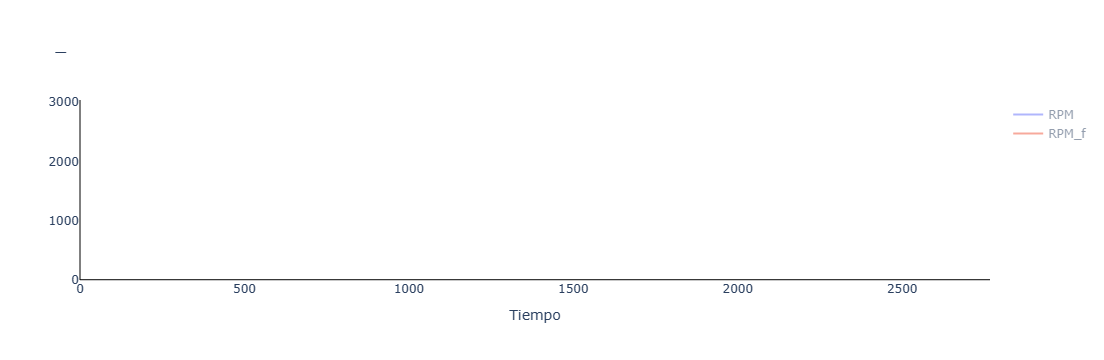

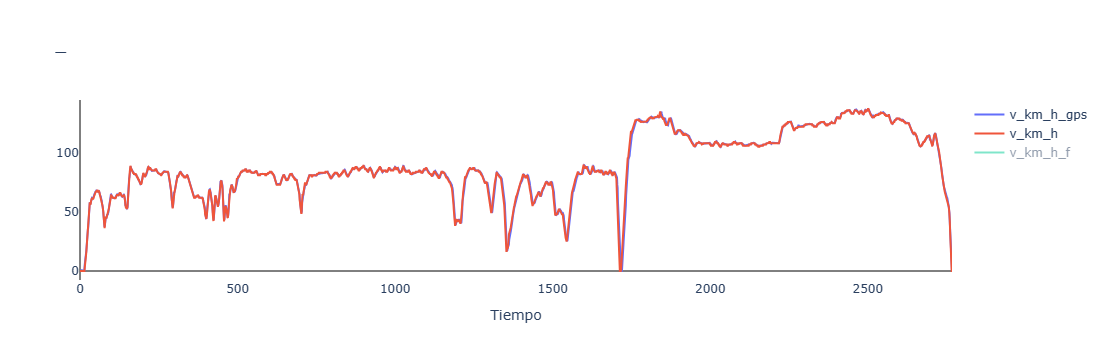

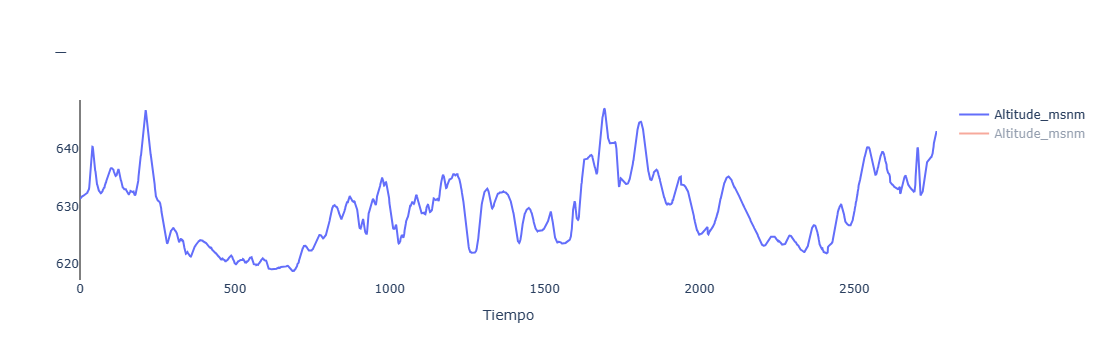

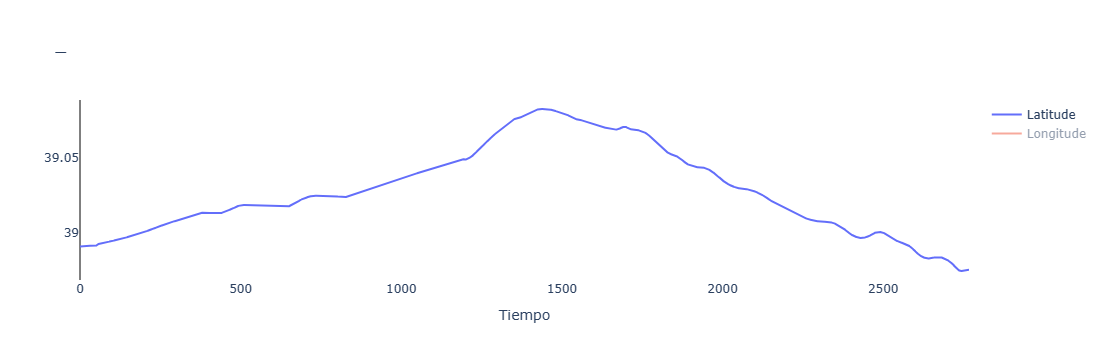

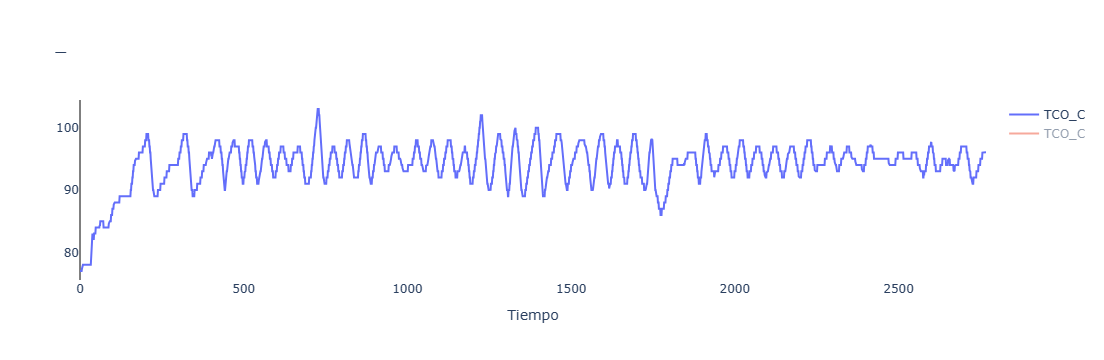

In [8]:
# RPM
fig = go.Figure(data=[go.Scatter(x = df_int["t_s"], y = df_int["RPM"], name = "RPM", mode="lines"),
                      go.Scatter(x = df_int["t_s"], y = df_int["RPM_f"], name = "RPM_f", mode="lines",visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()


# Velocidad
fig = go.Figure(data=[go.Scatter(x = df_int["t_s"], y = df_int["v_km_h_gps"], name = "v_km_h_gps", mode="lines"),
                      go.Scatter(x = df_int["t_s"], y = df_int["v_km_h"], name = "v_km_h", mode="lines"),
                      go.Scatter(x = df_int["t_s"], y = df_int["v_km_h_f"], name = "v_km_h_f", mode="lines",visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

# # Disnacia acumulada
# fig = go.Figure(data=[go.Scatter(x = df_int["t_s"], y = df_int['distance'], name = "distance", mode="lines"),
#                       go.Scatter(x = df_int["t_s"], y = df_int["distance"], name = "distance", mode="lines", visible = "legendonly")])

# fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
# fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
# fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
# fig.show()

#GPS altimetria
fig = go.Figure(data=[go.Scatter(x = df_int["t_s"], y = df_int['Altitude_msnm'], name = "Altitude_msnm", mode="lines"),
                      go.Scatter(x = df_int["t_s"], y = df_int["Altitude_msnm"], name = "Altitude_msnm", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

#GPS
fig = go.Figure(data=[go.Scatter(x = df_int["t_s"], y = df_int['Latitude'], name = "Latitude", mode="lines"),
                      go.Scatter(x = df_int["t_s"], y = df_int["Longitude"], name = "Longitude", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

# TCO
fig = go.Figure(data=[go.Scatter(x = df_int["t_s"], y = df_int['TCO_C'], name = "TCO_C", mode="lines"),
                      go.Scatter(x = df_int["t_s"], y = df_int["TCO_C"], name = "TCO_C", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

In [12]:
# Crear DF con solo los datos de autopista
df_int_Aut = df_int.loc[df_int['intervalo'] == 'Motorway']


# Calcula el cambio en el tiempo
df_int_Aut['delta_tiempo'] = df_int_Aut['t_s'].diff().fillna(0)
# Calcula la distancia recorrida en cada intervalo de tiempo
df_int_Aut['distance'] = df_int_Aut['v_km_h_f']/3.6 * df_int_Aut['delta_tiempo']
# Calcula la distancia acumulada en km
df_int_Aut['distance'] = (df_int_Aut['distance'].cumsum())/1000 # en km

# Guardar DF Autopista:
df_int_Aut.to_csv('RDE_Motorway_CR_05042024.csv', index=False)


# Crear DF con solo los datos de rural
df_int_Rural = df_int.loc[df_int['intervalo'] == 'Rural']

# Calcula el cambio en el tiempo
df_int_Rural['delta_tiempo'] = df_int_Rural['t_s'].diff().fillna(0)
# Calcula la distancia recorrida en cada intervalo de tiempo
df_int_Rural['distance'] = df_int_Rural['v_km_h_f']/3.6 * df_int_Rural['delta_tiempo']
# Calcula la distancia acumulada en km
df_int_Rural['distance'] = (df_int_Rural['distance'].cumsum())/1000 # en km

# Guardar DF Rural
df_int_Rural.to_csv('RDE_Rural_CR_05042024.csv', index=False)


# diff = df_int_Aut["distance"].min()
# diff
# df_int_Aut["distance"] = df_int_Aut["distance"] - diff

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18424\1752231126.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18424\1752231126.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18424\1752231126.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

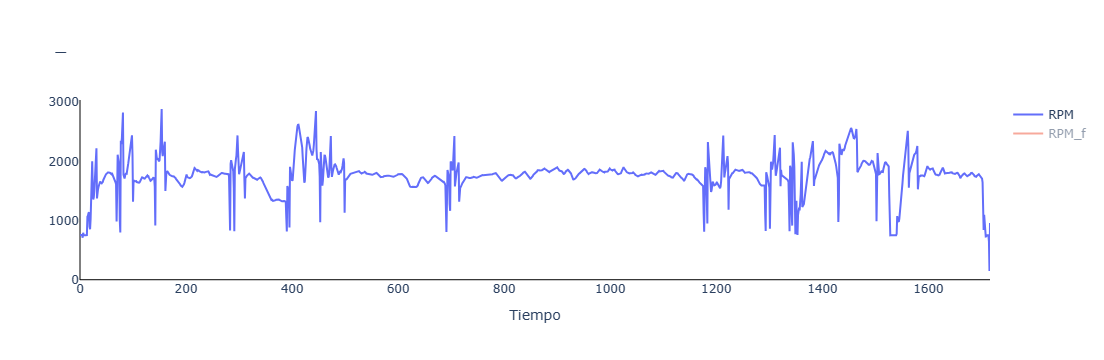

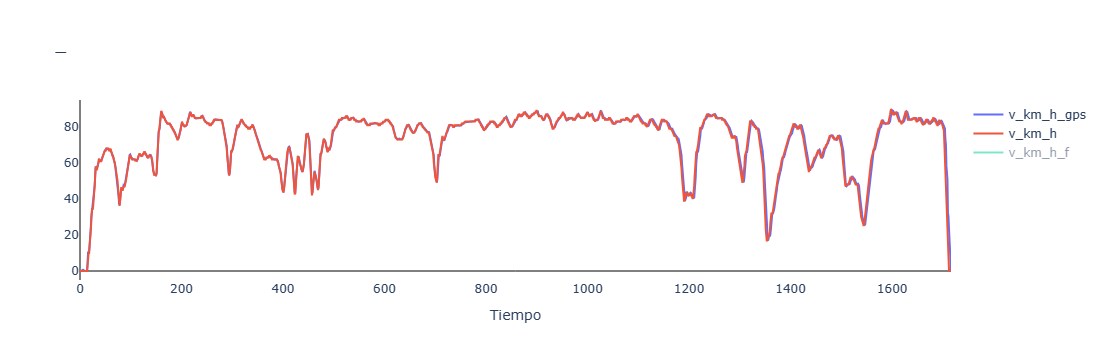

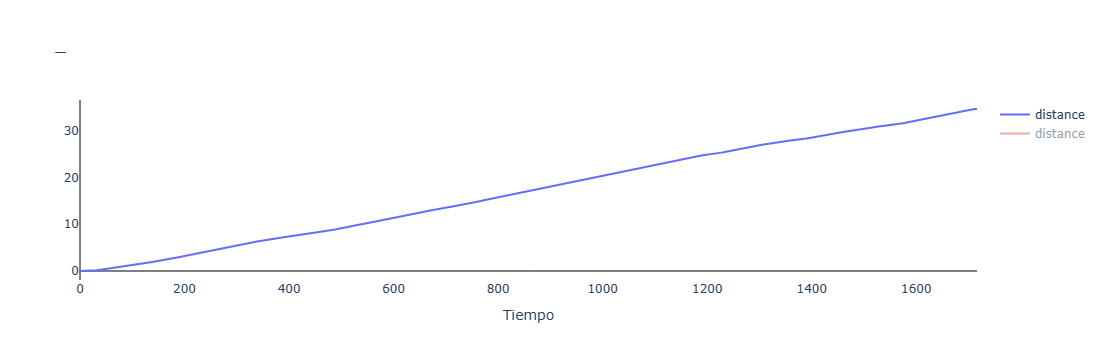

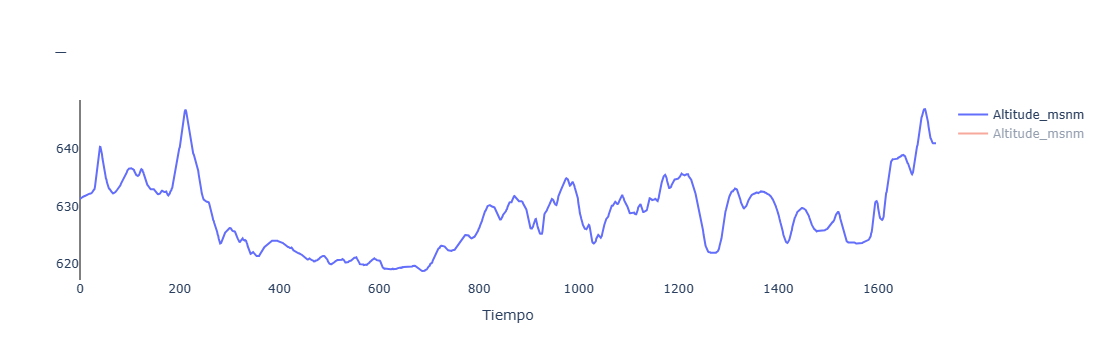

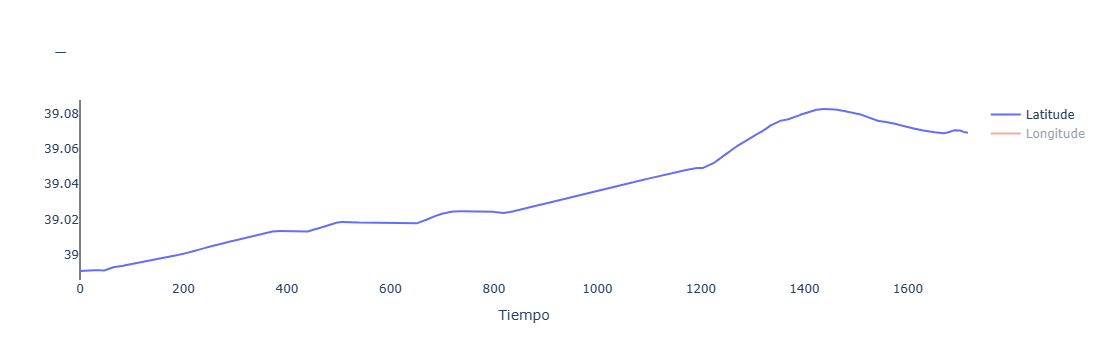

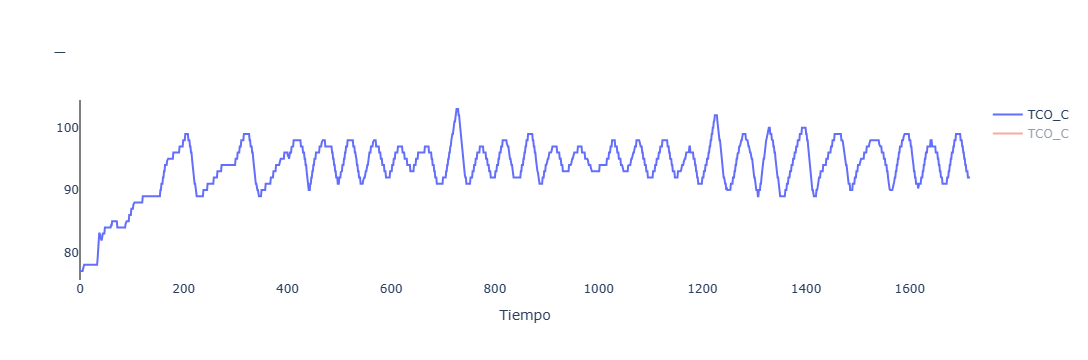

In [11]:


# RPM
fig = go.Figure(data=[go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["RPM"], name = "RPM", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["RPM_f"], name = "RPM_f", mode="lines",visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()


# Velocidad
fig = go.Figure(data=[go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["v_km_h_gps"], name = "v_km_h_gps", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["v_km_h"], name = "v_km_h", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["v_km_h_f"], name = "v_km_h_f", mode="lines",visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

# Disnacia acumulada
fig = go.Figure(data=[go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural['distance'], name = "distance", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["distance"], name = "distance", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

#GPS altimetria
fig = go.Figure(data=[go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural['Altitude_msnm'], name = "Altitude_msnm", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["Altitude_msnm"], name = "Altitude_msnm", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

#GPS
fig = go.Figure(data=[go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural['Latitude'], name = "Latitude", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["Longitude"], name = "Longitude", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()

# TCO
fig = go.Figure(data=[go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural['TCO_C'], name = "TCO_C", mode="lines"),
                      go.Scatter(x = df_int_Rural["t_s"], y = df_int_Rural["TCO_C"], name = "TCO_C", mode="lines", visible = "legendonly")])

fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="Tiempo")
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='black', title_text="")
fig.update_layout(height=300, width=900, title_text="_",plot_bgcolor="white")
fig.show()